In [1]:
import os
import requests
import pandas as pd
from bs4 import BeautifulSoup
import seaborn as sb
import matplotlib.pyplot as plt
import matplotlib as mpl
import warnings
import numpy as np
from math import pi
from urllib.request import urlopen
import matplotlib.patheffects as pe
from highlight_text import fig_text
from adjustText import adjust_text
from tabulate import tabulate
import matplotlib.style as style
import unicodedata
from fuzzywuzzy import fuzz
from fuzzywuzzy import process
import matplotlib.ticker as ticker
import matplotlib.patheffects as path_effects
import matplotlib.font_manager as fm
import matplotlib.colors as mcolors
from matplotlib import cm
from highlight_text import fig_text

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from sklearn.cluster import KMeans
from sklearn import preprocessing
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler

style.use('fivethirtyeight')

from PIL import Image
import urllib
import os
import math
from PIL import Image
import matplotlib.image as image
pd.options.display.max_columns = None

/Users/stephenahiabah/anaconda3/lib/python3.7/site-packages/fuzzywuzzy/fuzz.py:11: UserWarning: Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning
  warnings.warn('Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning')
/Users/stephenahiabah/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/least_angle.py:35: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  eps=np.finfo(np.float).eps,
/Users/stephenahiabah/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/least_angle.py:597: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warnin

In [2]:
keepers = ['GK']
defenders = ["DF",'DF,MF']
wing_backs = ['FW,DF','DF,FW']
midfielders = ['MF,DF','MF']
forwards = ['FW','MF,FW',"FW,MF"]
def position_grouping(x):
    if x in keepers:
        return "GK"
    elif x in defenders:
        return "Defender"
    elif x in wing_backs:
        return "Wing-Back"
    elif x in midfielders:
        return "Central Midfielders"
    elif x in forwards:
        return "Forwards"
    else:
        return "unidentified position"

In [3]:
fbref_passing = 'https://fbref.com/en/comps/9/passing/Premier-League-Stats'
fbref_shooting = 'https://fbref.com/en/comps/9/shooting/Premier-League-Stats'
fbref_pass_type = 'https://fbref.com/en/comps/9/passing_types/Premier-League-Stats'
fbref_defence = 'https://fbref.com/en/comps/9/gca/Premier-League-Stats'
fbref_gca = 'https://fbref.com/en/comps/9/defense/Premier-League-Stats'
fbref_poss = 'https://fbref.com/en/comps/9/possession/Premier-League-Stats'
fbref_misc = 'https://fbref.com/en/comps/9/misc/Premier-League-Stats'


In [8]:
def create_full_stats_db(fbref_passing,fbref_shooting,fbref_pass_type,fbref_defence,fbref_gca,fbref_poss,fbref_misc):
    # Passing columns 
    pass_ = fbref_passing
    page =requests.get(pass_)
    soup = BeautifulSoup(page.content, 'html.parser')
    html_content = requests.get(pass_).text.replace('<!--', '').replace('-->', '')
    pass_df = pd.read_html(html_content)
    pass_df[-1].columns = pass_df[-1].columns.droplevel(0)
    pass_stats = pass_df[-1]
    pass_prefixes = {1: 'Total - ', 2: 'Short - ', 3: 'Medium - ', 4: 'Long - '}
    pass_column_occurrences = {'Cmp': 0, 'Att': 0, 'Cmp%': 0}
    pass_new_column_names = []
    for col_name in pass_stats.columns:
        if col_name in pass_column_occurrences:
            pass_column_occurrences[col_name] += 1
            prefix = pass_prefixes[pass_column_occurrences[col_name]]
            pass_new_column_names.append(prefix + col_name)
        else:
            pass_new_column_names.append(col_name)
    pass_stats.columns = pass_new_column_names
    pass_stats = pass_stats[pass_stats['Player'] != 'Player']

    # Shooting columns 
    shot_ = fbref_shooting
    page =requests.get(shot_)
    soup = BeautifulSoup(page.content, 'html.parser')
    html_content = requests.get(shot_).text.replace('<!--', '').replace('-->', '')
    shot_df = pd.read_html(html_content)
    shot_df[-1].columns = shot_df[-1].columns.droplevel(0) # drop top header row
    shot_stats = shot_df[-1]
    shot_stats = shot_stats[shot_stats['Player'] != 'Player']    



    # Pass Type columns 
    pass_type = fbref_pass_type
    page =requests.get(pass_type)
    soup = BeautifulSoup(page.content, 'html.parser')
    html_content = requests.get(pass_type).text.replace('<!--', '').replace('-->', '')
    pass_type_df = pd.read_html(html_content)
    pass_type_df[-1].columns = pass_type_df[-1].columns.droplevel(0) # drop top header row
    pass_type_stats = pass_type_df[-1]
    pass_type_stats = pass_type_stats[pass_type_stats['Player'] != 'Player']


    # GCA columns 
    gca_ = fbref_gca
    page =requests.get(gca_)
    soup = BeautifulSoup(page.content, 'html.parser')
    html_content = requests.get(gca_).text.replace('<!--', '').replace('-->', '')
    gca_df = pd.read_html(html_content)
    gca_df[-1].columns = gca_df[-1].columns.droplevel(0)
    gca_stats = gca_df[-1]
    gca_prefixes = {1: 'SCA - ', 2: 'GCA - '}
    gca_column_occurrences = {'PassLive': 0, 'PassDead': 0, 'TO%': 0, 'Sh': 0, 'Fld': 0, 'Def': 0}
    gca_new_column_names = []
    for col_name in gca_stats.columns:
        if col_name in gca_column_occurrences:
            gca_column_occurrences[col_name] += 1
            prefix = gca_prefixes[gca_column_occurrences[col_name]]
            gca_new_column_names.append(prefix + col_name)
        else:
            gca_new_column_names.append(col_name)
    gca_stats.columns = gca_new_column_names
    gca_stats = gca_stats[gca_stats['Player'] != 'Player']
    

    # Defense columns 
    defence_ = fbref_defence
    page =requests.get(defence_)
    soup = BeautifulSoup(page.content, 'html.parser')
    html_content = requests.get(defence_).text.replace('<!--', '').replace('-->', '')
    defence_df = pd.read_html(html_content)
    defence_df[-1].columns = defence_df[-1].columns.droplevel(0) # drop top header row
    defence_stats = defence_df[-1]
    rename_columns = {
    'Def 3rd': 'Tackles - Def 3rd',
    'Mid 3rd': 'Tackles - Mid 3rd',
    'Att 3rd': 'Tackles - Att 3rd',
    'Blocks': 'Total Blocks',
    'Sh': 'Shots Blocked',
    'Pass': 'Passes Blocked'}
    defence_stats.rename(columns = rename_columns, inplace=True)
    defence_prefixes = {1: 'Total - ', 2: 'Dribblers- '}
    defence_column_occurrences = {'Tkl': 0}
    new_column_names = []
    for col_name in defence_stats.columns:
        if col_name in defence_column_occurrences:
            defence_column_occurrences[col_name] += 1
            prefix = defence_prefixes[defence_column_occurrences[col_name]]
            new_column_names.append(prefix + col_name)
        else:
            new_column_names.append(col_name)
    defence_stats.columns = new_column_names
    defence_stats = defence_stats[defence_stats['Player'] != 'Player']


    # possession columns 
    poss_ = fbref_poss
    page =requests.get(poss_)
    soup = BeautifulSoup(page.content, 'html.parser')
    html_content = requests.get(poss_).text.replace('<!--', '').replace('-->', '')
    poss_df = pd.read_html(html_content)
    poss_df[-1].columns = poss_df[-1].columns.droplevel(0) # drop top header row
    poss_stats = poss_df[-1]
    rename_columns = {
    'TotDist': 'Carries - TotDist',
    'PrgDist': 'Carries - PrgDist',
    'PrgC': 'Carries - PrgC',
    '1/3': 'Carries - 1/3',
    'CPA': 'Carries - CPA',
    'Mis': 'Carries - Mis',
    'Dis': 'Carries - Dis',
    'Att': 'Take Ons - Attempted'  }
    poss_stats.rename(columns=rename_columns, inplace=True)
    poss_stats = poss_stats[poss_stats['Player'] != 'Player']


    # misc columns 
    misc_ = fbref_misc
    page =requests.get(misc_)
    soup = BeautifulSoup(page.content, 'html.parser')
    html_content = requests.get(misc_).text.replace('<!--', '').replace('-->', '')
    misc_df = pd.read_html(html_content)
    misc_df[-1].columns = misc_df[-1].columns.droplevel(0) # drop top header row
    misc_stats = misc_df[-1]
    misc_stats = misc_stats[misc_stats['Player'] != 'Player']

    index_df = misc_stats[['Player', 'Nation', 'Pos', 'Squad', 'Age', 'Born', '90s']]

    data_frames = [poss_stats, misc_stats, pass_stats ,defence_stats, shot_stats, gca_stats, pass_type_stats]
    for df in data_frames:
        if df is not None:  # Checking if the DataFrame exists
            df.drop(columns=['Matches', 'Rk', 'Comp'], inplace=True, errors='ignore')
            df.dropna(axis=0, how='any', inplace=True)

            index_df = pd.merge(index_df, df, on=['Player', 'Nation', 'Pos', 'Squad', 'Age', 'Born', '90s'], how='left')
    index_df["position_group"] = index_df.Pos.apply(lambda x: position_grouping(x))  

    index_df.fillna(0, inplace=True)

    non_numeric_cols = ['Player', 'Nation', 'Pos', 'Squad', 'Age', 'position_group']
    
    def clean_non_convertible_values(value):
        try:
            return pd.to_numeric(value)
        except (ValueError, TypeError):
            return np.nan

    index_df = index_df.reset_index()

    # Iterate through each column, converting non-numeric columns to numeric
    for col in index_df.columns:
        if col not in non_numeric_cols:
            index_df[col] = index_df[col].apply(clean_non_convertible_values)

    
    return index_df



In [9]:
def per_90fi(dataframe):
    # Replace empty strings ('') with NaN
    dataframe = dataframe.replace('', np.nan)
    
    # Fill NaN values with 0
    dataframe = dataframe.fillna(0)
    
    # Identify numeric columns excluding '90s' and columns with '90' or '%' in their names
    exclude_columns = ['Player', 'Nation', 'Pos', 'Squad', 'Age', 'Born', 'position_group']
    numeric_columns = [col for col in dataframe.columns if np.issubdtype(dataframe[col].dtype, np.number) 
                       and col != '90s' and not any(exc_col in col for exc_col in exclude_columns)
                       and ('90' not in col) and ('%' not in col)]
    
    # Create a mask to avoid division by zero
    mask = (dataframe['90s'] != 0)
    
    # Divide each numeric column by the '90s' column row-wise
    dataframe.loc[mask, numeric_columns] = dataframe.loc[mask, numeric_columns].div(dataframe.loc[mask, '90s'], axis=0)

    return dataframe



In [10]:
stats = create_full_stats_db(fbref_passing,fbref_shooting,fbref_pass_type,fbref_defence,fbref_gca,fbref_poss,fbref_misc)

/Users/stephenahiabah/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:135: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [11]:
stats

,index,Player,Nation,Pos,Squad,Age,Born,90s,Touches,Def Pen,Def 3rd_x,Mid 3rd_x,Att 3rd_x,Att Pen,Live_x,Take Ons - Attempted,Succ,Succ%,Tkld,Tkld%,Carries,Carries - TotDist,Carries - PrgDist,Carries - PrgC,Carries - 1/3,Carries - CPA,Carries - Mis,Carries - Dis,Rec,PrgR,CrdY,CrdR,2CrdY,Fls,Fld_x,Off_x,Crs_x,Int_x,TklW_x,PKwon,PKcon,OG,Recov,Won,Lost_x,Won%,Total - Cmp,Total - Att,Total - Cmp%,TotDist,PrgDist,Short - Cmp,Short - Att,Short - Cmp%,Medium - Cmp,Medium - Att,Medium - Cmp%,Long - Cmp,Long - Att,Long - Cmp%,Ast,xAG,xA,A-xAG,KP,1/3,PPA,CrsPA,PrgP,SCA,SCA90,PassLive,PassDead,TO,Shots Blocked,Fld_y,Def,GCA,GCA90,PassLive,PassDead,TO,Shots Blocked,Fld_y,Def,Gls,Sh,SoT,SoT%,Sh/90,SoT/90,G/Sh,G/SoT,Dist,FK_x,PK,PKatt,xG,npxG,npxG/Sh,G-xG,np:G-xG,Tkl,TklW_y,Def 3rd_y,Mid 3rd_y,Att 3rd_y,Tkl,Att_x,Tkl%,Lost_y,Blocks_x,SCA - Sh,Pass,Int_y,Tkl+Int,Clr,Err,Att_y,Live_y,Dead,FK_y,TB,Sw,Crs_y,TI,CK,In,Out,Str,Cmp,Off_y,Blocks_y,position_group
0,0,Max Aarons,eng ENG,DF,Bournemouth,24-059,2000,12.1,615,37,223,264,137,11,615,31,12,38.7,11,35.5,314,1908,998,19,11,7,11,7,310,22,1,0,0,11,25,2,11,6,18,0,1,0,69,4,9,30.8,379,501,75.6,6256,2424,186,213,87.3,156,202,77.2,31,56,55.4,1,0.8,0.9,0.2,7,22,12,2,40,20,1.67,15,2,0,0,3,0,1,0.08,1,0,0,0,0,0,0,0,0,0.0,0.00,0.00,0.00,0.00,0.0,0,0,0,0.0,0.0,0.00,0.0,0.0,28,18,20,6,2,19,30,63.3,11,9,5,4,6,34,23,0,501,385,115,10,2,3,11,105,0,0,0,0,379,1,20,Defender
1,1,Bénie Adama Traore,ci CIV,"FW,MF",Sheffield Utd,21-094,2002,4.3,112,2,19,49,48,9,112,22,5,22.7,15,68.2,72,462,174,7,5,3,10,7,69,14,0,0,0,10,4,1,3,1,2,0,0,0,22,2,18,10.0,55,71,77.5,775,185,34,38,89.5,19,23,82.6,1,1,100.0,0,0.5,0.5,-0.5,4,2,7,1,9,6,1.40,6,0,0,0,0,0,1,0.23,1,0,0,0,0,0,0,1,1,100.0,0.23,0.23,0.00,0.00,15.3,0,0,0,0.3,0.3,0.27,-0.3,-0.3,4,2,1,2,1,0,4,0.0,4,4,1,3,1,5,1,0,71,65,5,0,2,0,3,0,0,0,0,0,55,1,4,Forwards
2,2,Tosin Adarabioyo,eng ENG,DF,Fulham,26-161,1997,11.0,860,112,428,403,30,17,860,3,1,33.3,0,0.0,489,2863,1719,4,5,0,2,4,616,2,1,0,0,4,3,0,0,17,7,0,0,0,24,42,15,73.7,620,738,84.0,12652,4612,164,186,88.2,385,428,90.0,67,105,63.8,0,0.1,0.1,-0.1,1,25,2,0,32,6,0.54,3,0,0,3,0,0,0,0.00,0,0,0,0,0,0,1,9,3,33.3,0.82,0.27,0.11,0.33,16.2,0,0,0,0.3,0.3,0.04,0.7,0.7,14,7,10,4,0,10,14,71.4,4,11,8,3,17,31,58,0,738,719,17,16,1,6,0,0,0,0,0,0,620,2,3,Defender
3,3,Elijah Adebayo,eng ENG,FW,Luton Town,26-056,1998,12.9,395,24,46,154,200,74,395,53,14,26.4,36,67.9,220,1218,355,14,11,11,56,25,281,85,1,0,0,22,11,11,4,5,0,0,0,0,30,38,38,50.0,128,177,72.3,1627,336,84,105,80.0,35,52,67.3,3,6,50.0,0,0.7,0.4,-0.7,14,7,3,0,19,26,2.02,18,0,3,4,1,0,3,0.23,1,0,0,2,0,0,9,28,12,42.9,2.17,0.93,0.32,0.75,9.5,0,0,0,5.6,5.6,0.20,3.4,3.4,1,0,1,0,0,0,9,0.0,9,8,1,7,5,6,23,0,177,175,1,0,1,0,4,1,0,0,0,0,128,1,4,Forwards
4,4,Simon Adingra,ci CIV,FW,Brighton,22-062,2002,15.2,724,17,111,226,397,90,724,79,31,39.2,42,53.2,482,3026,1724,67,30,37,27,17,501,188,2,0,0,18,11,11,53,12,12,0,0,0,74,8,5,61.5,405,539,75.1,5762,1031,256,313,81.8,122,163,74.8,16,26,61.5,1,2.1,1.6,-1.1,18,9,23,8,28,44,2.89,30,1,5,5,1,2,4,0.26,3,0,0,0,0,1,6,31,14,45.2,2.04,0.92,0.19,0.43,15.8,0,0,0,3.0,3.0,0.10,3.0,3.0,22,12,12,5,5,11,28,39.3,17,16,1,15,12,34,10,0,539,519,19,2,4,1,53,12,5,0,1,0,405,1,16,Forwards
5,5,Nayef Aguerd,ma MAR,DF,West Ham,27-339,1996,18.7,1222,176,643,536,45,18,1222,4,2,50.0,2,50.0,765,3678,2054,9,8,0,8,2,806,3,3,1,1,9,5,0,4,16,11,0,1,0,97,41,27,60.3,830,1044,79.5,17721,7957,293,314,93.3,396,429,92.3,131,277,47.3,0,0.2,0.3,-0.2,3,66,1,0,61,13,0.69,11,1,0,1,0,0,0,0.00,0,0,0,0,0,0,1,14,3,21.4,0.75,0.16,0.07,0.33,10.8,0,0,0,1.5,1.5,0.11,-0.5,-0.5,22,11,16,6,0,13,17,76.5,4,28,21,7,16,38,81,2,1044,978,64,47,1,28,4,5,0,0,0,0,830,2,5,Defender
6,6,Brandon Aguilera,cr CRC,FW,Nott'ham Forest,20-249,2003,0.1,0,0,0,0,0,0,0,0,0,0.0,0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0,0,0.0,0,0,0,0,0.0,0,0,0.0,0,0,0.0,0,0.0,0.0,0.0,0,0,0,0,0,0,0.00,0,0,0,0,0,0,0,0.00,0,0,0,0,0,0,0,0,0,0.0,0.00,0.00,0.00,0.00,0.0,0,0,0,0.0,0.0,0.00,0.0,0.0,0,0,0,0,0,0,0,0.0,0,0,0,0,0,0,0,0,8,8,0,0,0

In [12]:
position = "Defender"  

In [15]:
def key_stats_db(df,position):
    non_numeric_cols = ['Player', 'Nation', 'Pos', 'Squad', 'Age', 'position_group']
    core_stats = ['90s','Total - Cmp%','KP', 'TB','Sw','PPA', 'PrgP','Tkl%','Blocks_x', 'Tkl+Int','Clr', 'Carries - PrgDist','SCA90','GCA90','CrsPA','xA', 'Rec','PrgR','xG', 'Sh','SoT']
    df.dropna(axis=0, how='any', inplace=True)
    key_stats_df = df[df['position_group'] == position]
    key_stats_df = key_stats_df[non_numeric_cols + core_stats]
    key_stats_df = key_stats_df[key_stats_df['90s'] > 5]
    key_stats_df = per_90fi(key_stats_df)
    return key_stats_df


key_stats_df = key_stats_db(stats,position)

In [16]:
def create_metrics_scores(key_stats_df):
    # Define the key_stats grouped by the metrics
    core_stats = ['90s','Total - Cmp%','KP', 'TB','Sw','PPA', 'PrgP','Tkl%','Blocks_x', 'Tkl+Int','Clr', 'Carries - PrgDist','SCA90','GCA90','CrsPA','xA', 'Rec','PrgR','xG', 'Sh','SoT']
    passing_metrics = ['Total - Cmp%', 'KP', 'TB', 'Sw', 'PPA', 'PrgP']
    defending_metrics = ['Tkl%', 'Blocks_x', 'Tkl+Int', 'Clr']
    creation_metrics = ['Carries - PrgDist', 'SCA90', 'GCA90', 'CrsPA', 'xA', 'Rec', 'PrgR']
    shooting_metrics = ['xG', 'Sh', 'SoT']

    # Create a MinMaxScaler instance
    scaler = MinMaxScaler()

    # Normalize the metrics
    stats_normalized = key_stats_df.copy()  # Create a copy of the DataFrame
    stats_normalized[core_stats] = scaler.fit_transform(stats_normalized[core_stats])

    # Calculate scores for each metric grouping and scale to 0-10
    stats_normalized['Passing_Score'] = stats_normalized[passing_metrics].mean(axis=1) * 10
    stats_normalized['Defending_Score'] = stats_normalized[defending_metrics].mean(axis=1) * 10
    stats_normalized['Creation_Score'] = stats_normalized[creation_metrics].mean(axis=1) * 10
    stats_normalized['Shooting_Score'] = stats_normalized[shooting_metrics].mean(axis=1) * 10

    # Add a small offset to ensure unique scores
    stats_normalized['Passing_Score'] += stats_normalized.index * 0.001
    stats_normalized['Defending_Score'] += stats_normalized.index * 0.001
    stats_normalized['Creation_Score'] += stats_normalized.index * 0.001
    stats_normalized['Shooting_Score'] += stats_normalized.index * 0.001

    # Clip scores to ensure they are within the 0-10 range
    stats_normalized[['Passing_Score', 'Defending_Score', 'Creation_Score', 'Shooting_Score']] = stats_normalized[['Passing_Score', 'Defending_Score', 'Creation_Score', 'Shooting_Score']].clip(lower=0, upper=10)
    return stats_normalized

def adjust_player_rating_range(dataframe):
    # Get the 'total player rating' column
    player_ratings = dataframe[['Passing_Score', 'Defending_Score', 'Creation_Score', 'Shooting_Score']]
    
    # Define the desired range for the ratings
    min_rating = 4.5
    max_rating = 9.5
    
    # Normalize the ratings to be within the desired range (5 to 9.5) for each column
    for col in player_ratings.columns:
        normalized_ratings = min_rating + (max_rating - min_rating) * ((player_ratings[col] - player_ratings[col].min()) / (player_ratings[col].max() - player_ratings[col].min()))
        dataframe[col] = normalized_ratings
    
    return dataframe


pitch_iq_scoring = create_metrics_scores(key_stats_df)
pitch_iq_scoring = adjust_player_rating_range(pitch_iq_scoring)
pitch_iq_scoring = pitch_iq_scoring[['Player','Passing_Score', 'Defending_Score', 'Creation_Score', 'Shooting_Score']]
pitch_iq_scores = pd.merge(key_stats_df, pitch_iq_scoring, on='Player', how='left')


In [17]:
pitch_iq_scores

,Player,Nation,Pos,Squad,Age,position_group,90s,Total - Cmp%,KP,TB,Sw,PPA,PrgP,Tkl%,Blocks_x,Tkl+Int,Clr,Carries - PrgDist,SCA90,GCA90,CrsPA,xA,Rec,PrgR,xG,Sh,SoT,Passing_Score,Defending_Score,Creation_Score,Shooting_Score
0,Max Aarons,eng ENG,DF,Bournemouth,24-059,Defender,12.1,75.6,0.578512,0.165289,0.247934,0.991736,3.305785,63.3,0.743802,2.809917,1.900826,82.479339,1.67,0.08,0.165289,0.074380,25.619835,1.818182,0.000000,0.000000,0.000000,5.772128,5.900005,6.019131,4.500000
1,Tosin Adarabioyo,eng ENG,DF,Fulham,26-161,Defender,11.0,84.0,0.090909,0.090909,0.545455,0.181818,2.909091,71.4,1.000000,2.818182,5.272727,156.272727,0.54,0.00,0.000000,0.009091,56.000000,0.181818,0.027273,0.818182,0.272727,5.621596,7.572657,5.756995,6.156098
2,Nayef Aguerd,ma MAR,DF,West Ham,27-339,Defender,18.7,79.5,0.160428,0.053476,1.497326,0.053476,3.262032,76.5,1.497326,2.032086,4.331551,109.839572,0.69,0.00,0.000000,0.016043,43.101604,0.160428,0.080214,0.748663,0.160428,6.149493,7.527621,5.480698,6.292439
3,Anel Ahmedhodžić,ba BIH,DF,Sheffield Utd,24-343,Defender,19.5,76.1,0.051282,0.000000,0.051282,0.051282,1.384615,59.4,1.538462,3.333333,4.512821,62.512821,0.97,0.05,0.000000,0.005128,25.179487,0.871795,0.128205,0.769231,0.153846,4.674779,7.915785,5.277136,6.703716
4,Ola Aina,ng NGA,DF,Nott'ham Forest,27-147,Defender,11.0,74.0,0.454545,0.090909,0.000000,0.272727,2.727273,73.9,0.909091,3.090909,3.454545,84.909091,1.55,0.09,0.090909,0.036364,25.000000,2.000000,0.018182,0.545455,0.090909,5.045695,7.017661,5.852117,5.416672
5,Rayan Aït Nouri,dz ALG,"DF,MF",Wolves,22-271,Defender,17.9,84.3,1.061453,0.111732,0.111732,0.558659,4.413408,62.1,1.284916,3.351955,1.675978,94.692737,2.50,0.11,0.111732,0.078212,38.715084,4.022346,0.089385,0.726257,0.055866,6.016361,6.687308,6.649381,6.128425
6,Kristoffer Ajer,no NOR,DF,Brentford,25-321,Defender,12.4,74.7,0.725806,0.080645,0.725806,0.161290,2.983871,64.0,1.129032,3.064516,3.951613,86.290323,1.69,0.16,0.161290,0.161290,31.290323,2.096774,0.056452,0.483871,0.080645,5.680573,7.219059,6.582852,5.652631
7,Manuel Akanji,ch SUI,"DF,MF",Manchester City,28-228,Defender,17.6,92.9,0.340909,0.227273,0.568182,0.511364,5.284091,53.8,1.193182,2.329545,2.897727,182.556818,1.87,0.17,0.056818,0.062500,73.011364,1.193182,0.051136,0.568182,0.227273,6.559636,6.332842,6.960378,6.005135
8,Nathan Aké,nl NED,DF,Manchester City,29-014,Defender,17.2,92.2,0.523256,0.058140,0.116279,0.232558,5.174419,68.8,0.697674,1.569767,2.209302,151.802326,1.92,0.35,0.058140,0.058140,66.511628,0.755814,0.093023,1.046512,0.232558,5.958901,5.473197,7.034218,6.866087
9,Trent Alexander-Arnold,eng ENG,DF,Liverpool,25-148,Defender,18.0,74.8,2.944444,1.055556,1.333333,2.333333,8.500000,29.9,0.722222,2.833333,2.166667,110.555556,5.49,0.39,0.666667,0.255556,60.388889,3.611111,0.100000,1.666667,0.222222,9.500000,5.270934,9.041334,7.549894


### K Means Clustering 

In [54]:
KMeans_cols = ['Player','Total - Cmp%','KP', 'TB','Sw','PPA', 'PrgP','Tkl%','Blocks_x', 'Tkl+Int','Clr', 'Carries - PrgDist','SCA90','GCA90','CrsPA','xA', 'Rec','PrgR','xG', 'Sh','SoT']

df = key_stats_df[KMeans_cols]
player_names = df['Player'].tolist() 

df = df.drop(['Player'], axis = 1) 

x = df.values 
scaler = preprocessing.MinMaxScaler()
x_scaled = scaler.fit_transform(x)
X_norm = pd.DataFrame(x_scaled)

pca = PCA(n_components = 2)
reduced = pd.DataFrame(pca.fit_transform(X_norm))

In [55]:
reduced.head()

,0,1
0,0.064888,-0.271312
1,-0.529930,0.213366
2,-0.521891,0.228751
3,-0.377104,-0.309356
4,-0.108166,-0.311244


In [56]:
wcss = [] 
for i in range(1, 11): 
    kmeans = KMeans(n_clusters = i, init = 'k-means++', random_state = 42)
    kmeans.fit(reduced) 
    wcss.append(kmeans.inertia_)

/Users/stephenahiabah/anaconda3/lib/python3.7/site-packages/sklearn/metrics/pairwise.py:54: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype = np.float
/Users/stephenahiabah/anaconda3/lib/python3.7/site-packages/sklearn/metrics/pairwise.py:54: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype = np.float
/Users/stephenahiabah/anaconda

Text(0, 0.5, 'WCSS')

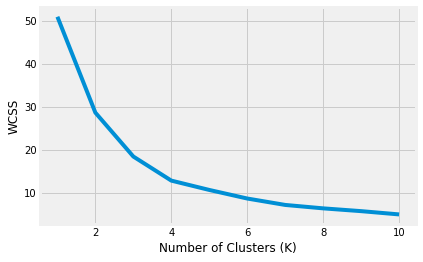

In [57]:
plt.plot(range(1, 11), wcss)
plt.xlabel('Number of Clusters (K)')
plt.ylabel('WCSS') 

In [58]:
kmeans = KMeans(n_clusters=7)
kmeans = kmeans.fit(reduced)

labels = kmeans.predict(reduced)
clusters = kmeans.labels_.tolist()

reduced['cluster'] = clusters
reduced['name'] = player_names
reduced.columns = ['x', 'y', 'cluster', 'name']
reduced.head()

/Users/stephenahiabah/anaconda3/lib/python3.7/site-packages/sklearn/metrics/pairwise.py:54: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype = np.float
/Users/stephenahiabah/anaconda3/lib/python3.7/site-packages/sklearn/metrics/pairwise.py:54: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype = np.float
/Users/stephenahiabah/anaconda

,x,y,cluster,name
0,0.064888,-0.271312,1,Max Aarons
1,-0.529930,0.213366,2,Tosin Adarabioyo
2,-0.521891,0.228751,2,Nayef Aguerd
3,-0.377104,-0.309356,5,Anel Ahmedhodžić
4,-0.108166,-0.311244,1,Ola Aina


In [59]:
def create_kmeans_df(df): 
    KMeans_cols = ['Player','Total - Cmp%','KP', 'TB','Sw','PPA', 'PrgP','Tkl%','Blocks_x', 'Tkl+Int','Clr', 'Carries - PrgDist','SCA90','GCA90','CrsPA','xA', 'Rec','PrgR','xG', 'Sh','SoT']

    df = df[KMeans_cols]
    player_names = df['Player'].tolist() 

    df = df.drop(['Player'], axis = 1) 

    x = df.values 
    scaler = preprocessing.MinMaxScaler()
    x_scaled = scaler.fit_transform(x)
    X_norm = pd.DataFrame(x_scaled)

    pca = PCA(n_components = 2)
    reduced = pd.DataFrame(pca.fit_transform(X_norm))

    wcss = [] 
    for i in range(1, 11): 
        kmeans = KMeans(n_clusters = i, init = 'k-means++', random_state = 42)
        kmeans.fit(reduced) 
        wcss.append(kmeans.inertia_)

    kmeans = KMeans(n_clusters=7)
    kmeans = kmeans.fit(reduced)

    labels = kmeans.predict(reduced)
    clusters = kmeans.labels_.tolist()

    reduced['cluster'] = clusters
    reduced['name'] = player_names
    reduced.columns = ['x', 'y', 'cluster', 'name']
    reduced.head()

    return reduced

kmeans_df = create_kmeans_df(key_stats_df)



/Users/stephenahiabah/anaconda3/lib/python3.7/site-packages/sklearn/metrics/pairwise.py:54: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype = np.float
/Users/stephenahiabah/anaconda3/lib/python3.7/site-packages/sklearn/metrics/pairwise.py:54: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype = np.float
/Users/stephenahiabah/anaconda

/Users/stephenahiabah/anaconda3/lib/python3.7/site-packages/sklearn/metrics/pairwise.py:54: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype = np.float
/Users/stephenahiabah/anaconda3/lib/python3.7/site-packages/sklearn/metrics/pairwise.py:54: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype = np.float
/Users/stephenahiabah/anaconda

/Users/stephenahiabah/anaconda3/lib/python3.7/site-packages/seaborn/regression.py:546: UserWarning: The `size` paramter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


/Users/stephenahiabah/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:35: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


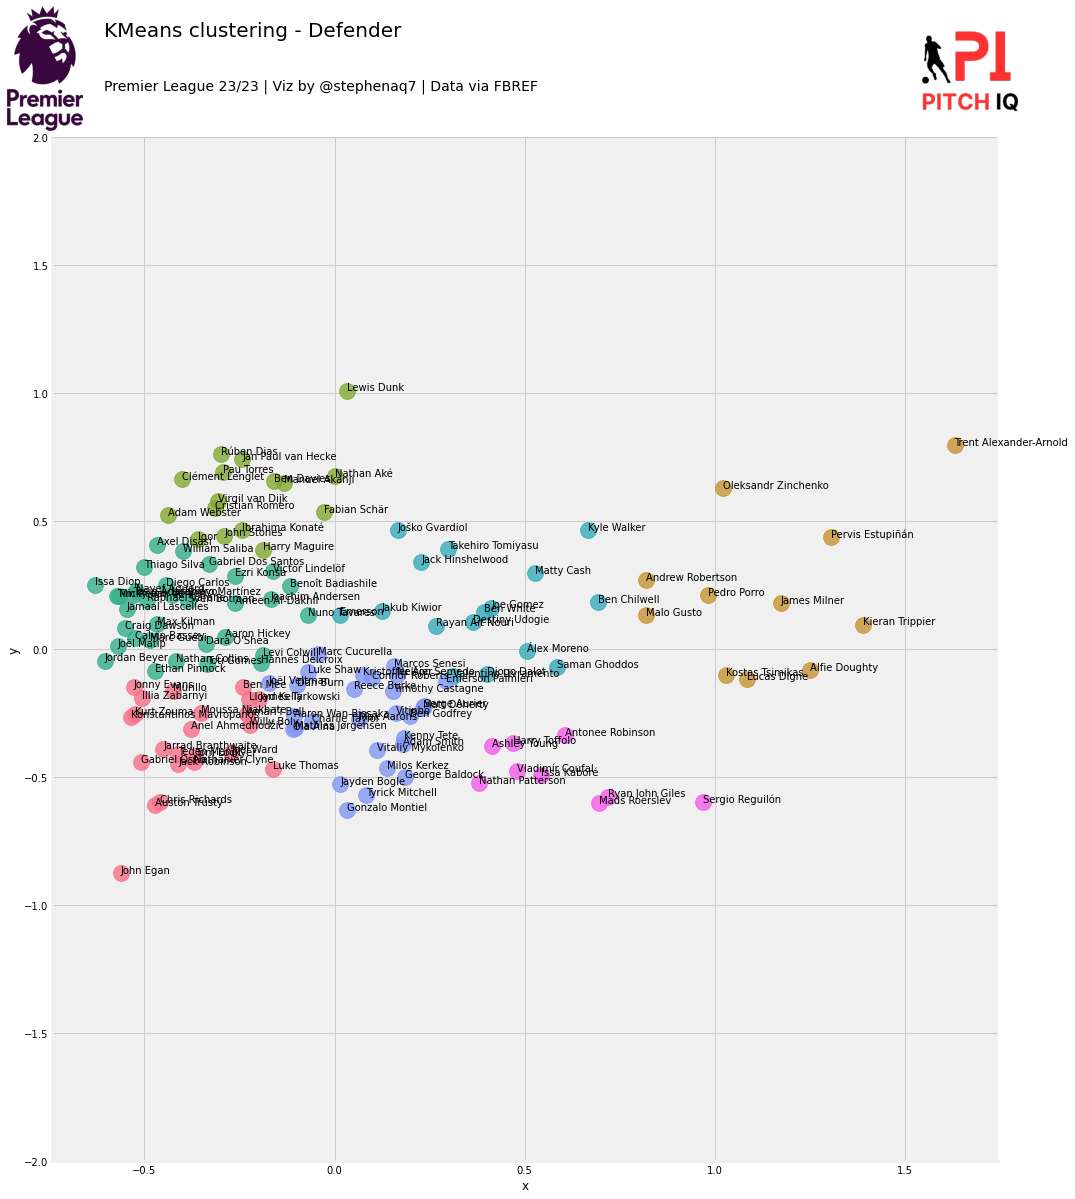

In [60]:
def create_clustering_chart(df,position):
    # Create the scatter plot using lmplot
    ax = sns.lmplot(x="x", y="y", hue='cluster', data=df, legend=False,
                    fit_reg=False, size=15, scatter_kws={"s": 250})

    texts = []
    for x, y, s in zip(df.x, df.y, df.name):
        texts.append(plt.text(x, y, s,fontweight='light'))


    # Additional axes for logos and titles
    fig = plt.gcf()
    ax1 = plt.gca()

    # Add title and logos to the current figure
    fig.text(.1, 1.08, f'KMeans clustering - {position}', size=20, font='Karla')
    fig.text(.1, 1.03, 'Premier League 23/23 | Viz by @stephenaq7 | Data via FBREF', size=14, font='Karla')

    ax2 = fig.add_axes([0.01, 0.175, 0.07, 1.75])
    ax2.axis('off')
    img = image.imread('/Users/stephenahiabah/Desktop/GitHub/Webs-scarping-for-Fooball-Data-/Images/premier-league-2-logo.png')
    ax2.imshow(img)

    ax3 = fig.add_axes([0.85, 0.175, 0.1, 1.75])
    ax3.axis('off')
    img = image.imread('/Users/stephenahiabah/Desktop/GitHub/Webs-scarping-for-Fooball-Data-/outputs/piqmain.png')
    ax3.imshow(img)

    # Set axis limits and labels for the lmplot
    ax1.set(ylim=(-2, 2))
    plt.tick_params(labelsize=15)
    plt.xlabel("PC 1", fontsize=20)
    plt.ylabel("PC 2", fontsize=20)

    plt.tight_layout()
    plt.show()
    
create_clustering_chart(kmeans_df,position)

In [61]:
kmeans_df[kmeans_df['cluster'] == 6]

,x,y,cluster,name
30,0.479135,-0.476952,6,Vladimír Coufal
60,0.719249,-0.574959,6,Ryan John Giles
62,0.543163,-0.491297,6,Issa Kaboré
90,0.379519,-0.521756,6,Nathan Patterson
94,0.968511,-0.597817,6,Sergio Reguilón
98,0.606327,-0.334629,6,Antonee Robinson
100,0.694780,-0.601412,6,Mads Roerslev
115,0.467995,-0.365933,6,Harry Toffolo
132,0.412914,-0.377182,6,Ashley Young


In [62]:
for i in range(0,7):
    df = kmeans_df[kmeans_df['cluster'] == i]
    print(f'cluster - {i}')
    print(df)

cluster - 0
            x         y  cluster                     name
3   -0.377104 -0.309356        0         Anel Ahmedhodžić
15  -0.229627 -0.252026        0             Amari'i Bell
18  -0.223757 -0.293689        0               Willy Boly
20  -0.450902 -0.388260        0       Jarrad Branthwaite
27  -0.370890 -0.440204        0          Nathaniel Clyne
45  -0.561734 -0.875364        0                John Egan
48  -0.528608 -0.148987        0              Jonny Evans
63  -0.225936 -0.193391        0              Lloyd Kelly
73  -0.367030 -0.415285        0              Tom Lockyer
77  -0.534506 -0.264156        0  Konstantinos Mavropanos
78  -0.241071 -0.148769        0                  Ben Mee
79  -0.412408 -0.409532        0              Teden Mengi
84  -0.424452 -0.160814        0                  Murillo
86  -0.350927 -0.247066        0          Moussa Niakhate
88  -0.508110 -0.441514        0             Gabriel Osho
95  -0.458535 -0.597500        0           Chris Richards
99

In [65]:
KMeans_cols = ['Player','Total - Cmp%','KP', 'TB','Sw','PPA', 'PrgP','Tkl%','Blocks_x', 'Tkl+Int','Clr', 'Carries - PrgDist','SCA90','GCA90','CrsPA','xA', 'Rec','PrgR','xG', 'Sh','SoT']

key_stats_df_3d = key_stats_df[KMeans_cols]


/Users/stephenahiabah/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:27: MatplotlibDeprecationWarning: Calling gca() with keyword arguments was deprecated in Matplotlib 3.4. Starting two minor releases later, gca() will take no keyword arguments. The gca() function should only be used to get the current axes, or if no axes exist, create new axes with default keyword arguments. To create a new axes with non-default arguments, use plt.axes() or plt.subplot().


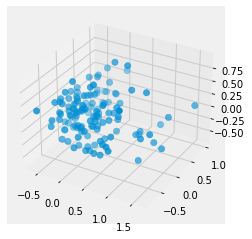

/Users/stephenahiabah/anaconda3/lib/python3.7/site-packages/sklearn/metrics/pairwise.py:54: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype = np.float
/Users/stephenahiabah/anaconda3/lib/python3.7/site-packages/sklearn/metrics/pairwise.py:54: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype = np.float
/Users/stephenahiabah/anaconda

/Users/stephenahiabah/anaconda3/lib/python3.7/site-packages/sklearn/metrics/pairwise.py:54: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype = np.float
/Users/stephenahiabah/anaconda3/lib/python3.7/site-packages/sklearn/metrics/pairwise.py:54: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype = np.float
/Users/stephenahiabah/anaconda

Text(0, 0.5, 'WCSS')

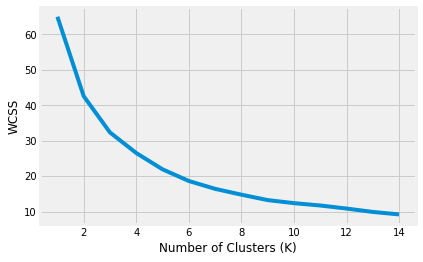

In [66]:
from sklearn import preprocessing

player_names_3d = key_stats_df_3d['Player'].tolist() 

df_3d = key_stats_df_3d.drop(['Player'], axis = 1) 

x = df_3d.values 
scaler = preprocessing.MinMaxScaler()
x_scaled = scaler.fit_transform(x)
X_norm = pd.DataFrame(x_scaled)

from sklearn.decomposition import PCA

pca = PCA(n_components = 3)
df1 = pd.DataFrame(pca.fit_transform(X_norm))

import re, seaborn as sns
from sklearn.cluster import KMeans
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.colors import ListedColormap


%matplotlib inline
df1.columns = ['PC1','PC2', 'PC3']

ax = plt.figure().gca(projection='3d')

ax.scatter(df1['PC1'], df1['PC2'], df1['PC3'], s=40)

plt.show()

wcss = [] 
for i in range(1, 15): 
  kmeans = KMeans(n_clusters = i, init = 'k-means++', random_state = 42)
  kmeans.fit(df1) 
  wcss.append(kmeans.inertia_)

plt.plot(range(1, 15), wcss)
plt.xlabel('Number of Clusters (K)')
plt.ylabel('WCSS')

In [67]:
kmeans = KMeans(n_clusters=9)
kmeans = kmeans.fit(df1)

labels = kmeans.predict(df1)
clusters = kmeans.labels_.tolist()

df1['cluster'] = clusters
df1['name'] = player_names
df1.columns = ['x', 'y', 'z', 'cluster', 'name']
df1

/Users/stephenahiabah/anaconda3/lib/python3.7/site-packages/sklearn/metrics/pairwise.py:54: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype = np.float
/Users/stephenahiabah/anaconda3/lib/python3.7/site-packages/sklearn/metrics/pairwise.py:54: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype = np.float
/Users/stephenahiabah/anaconda

,x,y,z,cluster,name
0,0.064888,-0.271312,-0.476338,3,Max Aarons
1,-0.529930,0.213366,0.101281,8,Tosin Adarabioyo
2,-0.521891,0.228751,0.272410,8,Nayef Aguerd
3,-0.377104,-0.309356,0.499643,4,Anel Ahmedhodžić
4,-0.108166,-0.311244,-0.076626,3,Ola Aina
5,0.267588,0.092730,0.044897,1,Rayan Aït Nouri
6,0.073957,-0.098687,0.028649,1,Kristoffer Ajer
7,-0.134114,0.651351,-0.149998,2,Manuel Akanji
8,-0.000188,0.676477,0.055294,2,Nathan Aké
9,1.629895,0.796995,0.166079,0,Trent Alexander-Arnold


In [72]:
for i in range(0,9):
    df = df1[df1['cluster'] == i]
    print(f'cluster - {i}')
    df

cluster - 0
cluster - 1
cluster - 2
cluster - 3
cluster - 4
cluster - 5
cluster - 6
cluster - 7
cluster - 8


In [81]:
df1[df1['cluster'] == 8]

,x,y,z,cluster,name
1,-0.529930,0.213366,0.101281,8,Tosin Adarabioyo
2,-0.521891,0.228751,0.272410,8,Nayef Aguerd
10,-0.167742,0.196910,0.067020,8,Joachim Andersen
19,-0.385776,0.188261,-0.025128,8,Sven Botman
22,-0.099495,-0.140410,0.415069,8,Dan Burn
28,-0.416358,-0.045476,0.022269,8,Nathan Collins
29,-0.187801,-0.021584,0.084223,8,Levi Colwill
31,-0.044238,-0.017534,0.378336,8,Marc Cucurella
32,-0.262776,0.179441,0.205589,8,Ameen Al-Dakhil
35,-0.551327,0.082282,0.267403,8,Craig Dawson


/Users/stephenahiabah/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: MatplotlibDeprecationWarning: Axes3D(fig) adding itself to the figure is deprecated since 3.4. Pass the keyword argument auto_add_to_figure=False and use fig.add_axes(ax) to suppress this warning. The default value of auto_add_to_figure will change to False in mpl3.5 and True values will no longer work in 3.6.  This is consistent with other Axes classes.
  


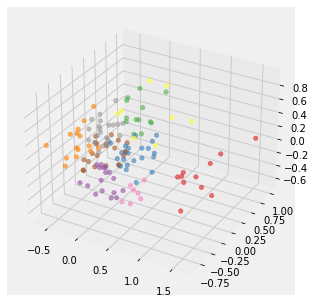

In [71]:

from matplotlib import pyplot as plt
from matplotlib import animation
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm

fig = plt.figure()
ax = Axes3D(fig)

def init():
    ax.scatter(df1['x'], df1['y'], df1['z'], marker='o', s=20, c=df1['cluster'], cmap=plt.get_cmap('Set1'), alpha=0.6)
    texts = []
    return fig,

def animate(i):
    ax.view_init(elev=10., azim=i)
    return fig,

anim = animation.FuncAnimation(fig, animate, init_func=init,
                               frames=360, interval=20, blit=True)

# anim.save('clusters_animation.mp4', fps=60, extra_args=['-vcodec', 'libx264'],dpi=300)